# Energy consumption prediction
* Brocco Mattia **|** 873058
* Piccolo Giulio **|** 874727

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

#import linear_model_tests as lmt
#import decision_tree_opt as dto
#import Data_viz as dv

#viz = dv.Graphs()
#lin_mod = lmt.Test()
#opt_tree = dto.Parameters()

%reload_ext autoreload
%autoreload 2

## DATA EXPLORATION AND CLEANSING

In [3]:
data = pd.read_csv(".\\data\\energydata_complete.csv", parse_dates = ["date"])
data = data.dropna()
names = ["date", "appliance_wh", "light_wh", "kitchen_celsius", "kitchen_hum_perc",
        "living_celsius", "living_hum_perc", "laundry_celsius", "laundry_hum_perc",
         "office_celsius", "office_hum_perc", "bathroom_celsius", "bathroom_hum_perc",
         "portico_celsius", "portico_hum_perc", "ironing_celsius", "ironing_hum_perc",
         "teen_celsius", "teen_hum_perc", "parents_celsius", "parents_hum_perc",
         "cws_celsius", "cws_pressure", "cws_hum_perc", "cws_wind", "cws_visibility",
         "cws_dew_point","rv1","rv2"]

data = data.rename(columns = dict(zip(data.columns, names)))
data = data.drop_duplicates(data.columns, keep = "last")

data = data.drop(["rv1", "rv2"], axis = 1)

print(data.shape)

(19735, 27)


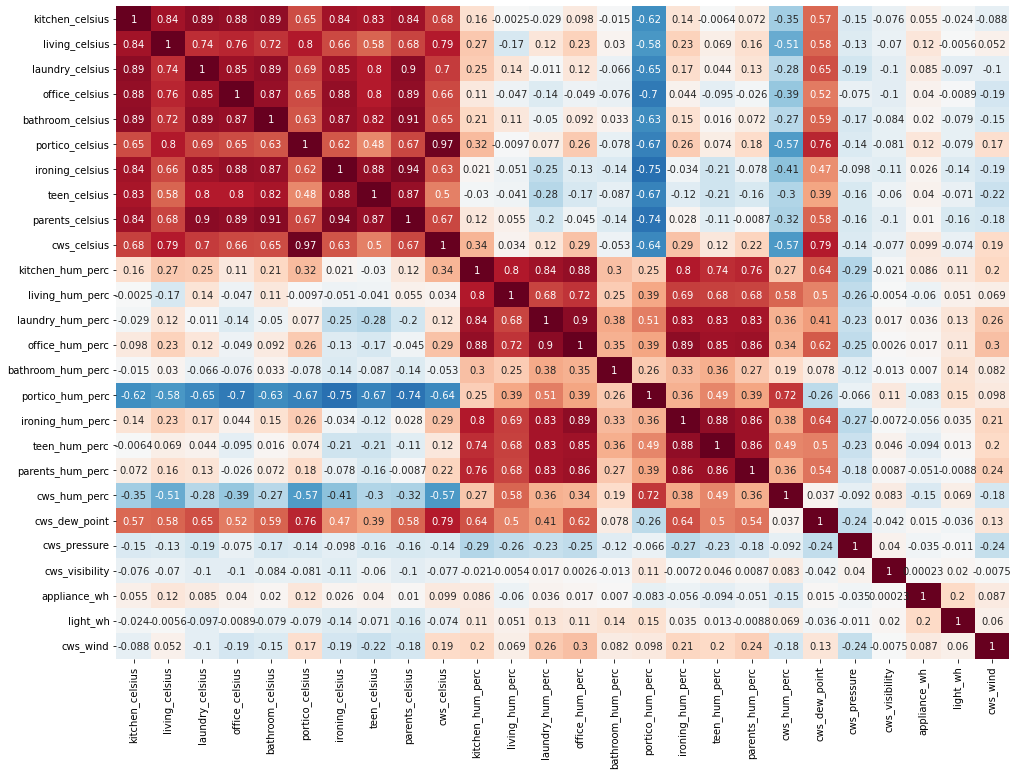

In [4]:
plt.figure(figsize = (16, 12))
# Correlation matrix grouping variables in temperature-related
# and humidity related. This highlights the block of variables
# that are highly correlated with each other.
sns.heatmap(data[sorted(data.columns, key = lambda s: s.split("_")[-1])].corr(),
            annot = True, cmap = "RdBu_r", vmin = -1, vmax = 1, cbar = False)
plt.show()

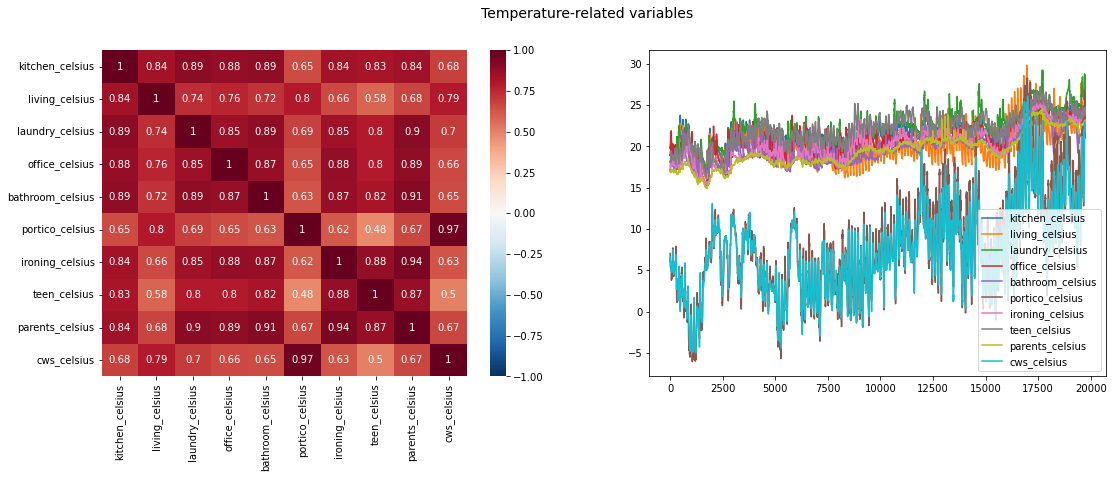

Variance
kitchen_celsius      2.579447
living_celsius       4.809133
laundry_celsius      4.024479
office_celsius       4.173377
bathroom_celsius     3.402635
portico_celsius     37.092322
ironing_celsius      4.452072
teen_celsius         3.826569
parents_celsius      4.059066
cws_celsius         28.274836
dtype: float64


In [5]:
# Intial features selection due to high collinearity
# TEMPERATURES
t_fig, t_ax = plt.subplots(1, 2, figsize = (18, 6))
sns.heatmap(data[[c for c in data.columns if "celsius" in c]].corr(),
            annot = True, cmap = "RdBu_r", vmin = -1, vmax = 1, ax = t_ax[0])


data[[c for c in data.columns if "celsius" in c]].plot(ax = t_ax[1])#.mean(axis = 1)
plt.suptitle("Temperature-related variables", fontsize = 14)
plt.show()

print("Variance")
print(data[[c for c in data.columns if "celsius" in c]].var())

###
# Introductory removal of features
# Remove: 'portico_celsius', 0.97 correlation with 'cws_celsius'
data = data.drop("portico_celsius", axis = 1)
###

# KEEP: cws_celsius (temperature measured by Chievres Weather Station)

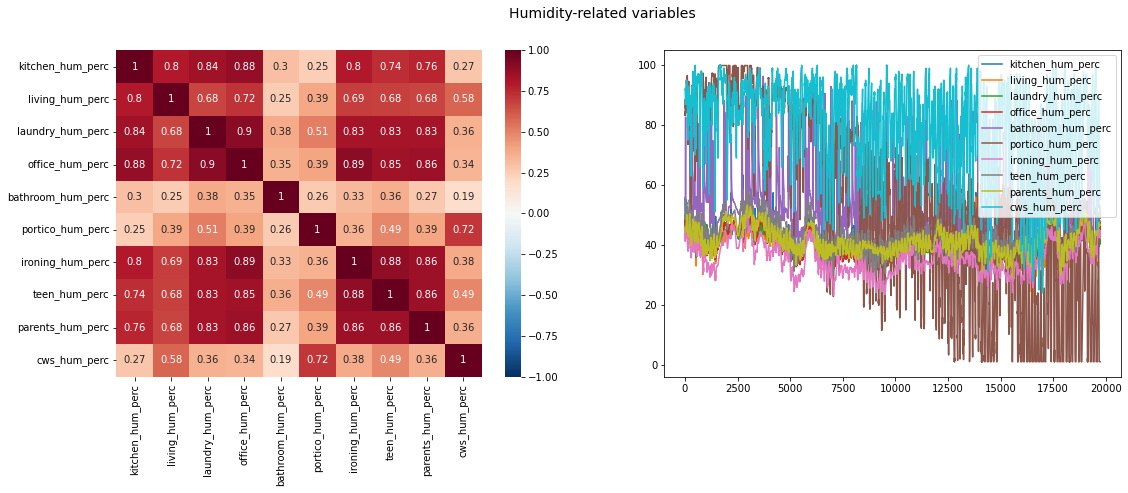

Variance
kitchen_hum_perc      15.834819
living_hum_perc       16.563374
laundry_hum_perc      10.592268
office_hum_perc       18.847065
bathroom_hum_perc     81.397103
portico_hum_perc     970.310406
ironing_hum_perc      26.155124
teen_hum_perc         27.293945
parents_hum_perc      17.234930
cws_hum_perc         222.042410
dtype: float64


In [6]:
# Intial features selection due to high collinearity
# PERCENTAGE OF HUMIDITY
h_fig, h_ax = plt.subplots(1, 2, figsize = (18, 6))
sns.heatmap(data[[c for c in data.columns if "hum_perc" in c]].corr(),
            annot = True, cmap = "RdBu_r", vmin = -1, vmax = 1, ax = h_ax[0])


data[[c for c in data.columns if "hum_perc" in c]].plot(ax = h_ax[1])#.mean(axis = 1)
plt.suptitle("Humidity-related variables", fontsize = 14)
plt.show()

print("Variance")
print(data[[c for c in data.columns if "hum_perc" in c]].var())

# KEEP: cws_celsius (temperature measured by Chievres Weather Station)

## PCA to reduce the number of features

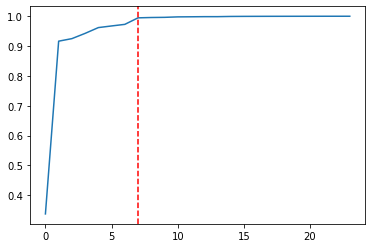

In [7]:
from sklearn.decomposition import PCA

X = data.drop(["date", "appliance_wh"], axis = 1)
y = np.log(data.appliance_wh)

pca = PCA(n_components = X.shape[1], random_state = 42)
pca.fit(X)

plt.plot(1 - pca.explained_variance_ratio_)
plt.axvline(7, ls = "--", color = "red")

pca7 = PCA(n_components = 7, random_state = 42)
pca7.fit(X)

X_rid = pca7.transform(X)

### Target, Features and Train Size
Set the target and the features matrices, with the train size equal to the 70% of the sample size

In [8]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

In [9]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_rid, y, train_size = 0.7,
                                                                    random_state = 42, shuffle = True)

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, train_size = 0.7,
                                                              random_state = 42, shuffle = True)

## LINEAR MODELS
* Linear Regression
* Lasso
* Support Vector Regressor

Linear regression R^2: 0.27277					Lasso R^2: 0.27095
Linear regression MSE: 0.31748					Lasso MSE: 0.31827


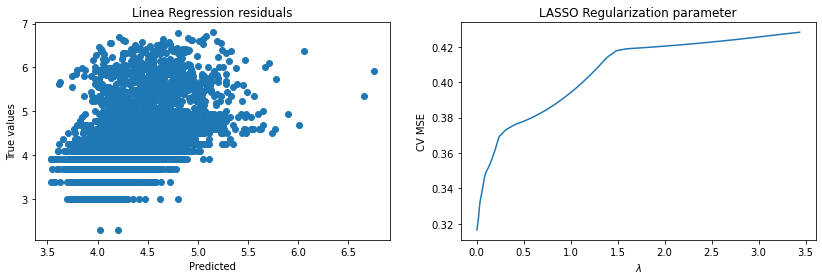

In [13]:
lr = LinearRegression(fit_intercept = True, n_jobs = -1)
lr.fit(X_train_full, y_train)

lr_pred = lr.predict(X_test_full)

#lin_par = opt_tree.evaluate(y_test, y_pred)

#lasso = lin_mod.lasso(data, X)
#recursive = lin_mod.recurs_elimin(data, X, y)
#viz.plot_2(data, model, lasso, recursive)
lasso_fig, lasso_ax = plt.subplots(1, 2, figsize = (14, 4))
lasso_ax[0].scatter(lr_pred, y_test)
lasso_ax[0].set_xlabel("Predicted")
lasso_ax[0].set_ylabel("True values")
lasso_ax[0].set_title("Linea Regression residuals")

lasso = LassoCV(cv = 10, n_jobs = -1, random_state = 42)
lasso.fit(X_train_full, y_train)

lasso_ax[1].plot(lasso.alphas_, lasso.mse_path_.mean(axis = 1))
lasso_ax[1].set_xlabel("$\lambda$")
lasso_ax[1].set_ylabel("CV MSE")
lasso_ax[1].set_title("LASSO Regularization parameter")

print("Linear regression R^2: {:.5f}\t\t\t\t\tLasso R^2: {:.5f}".format(r2_score(y_test, lr_pred),
                                                                        r2_score(y_test,
                                                                                 lasso.predict(X_test_full))))
print("Linear regression MSE: {:.5f}\t\t\t\t\tLasso MSE: {:.5f}".format(mean_squared_error(y_test, lr_pred),
                                                                        mean_squared_error(y_test,
                                                                                           lasso.predict(X_test_full))))

plt.show()

From the consideration of these linear models, by interpreting the problem at hand as a regression one, one can notice that, given the high amount of collinearity, the problem looks non-linear.

## DECISION TREE REGRESSOR

In [29]:
dt1 = DecisionTreeRegressor(random_state = 42)
dt2 = DecisionTreeRegressor(random_state = 42)

dt1.fit(X_train_pca, y_train)
dt2.fit(X_train_full, y_train)

# EX-POST PRUNING


path1 = tree.cost_complexity_pruning_path(X_train_pca, y_train)
ccp_alphas1, impurities1 = path1.ccp_alphas, path1.impurities

tree_grid_pca = GridSearchCV(DecisionTreeRegressor(random_state = 42),
                             {"ccp_alpha":[ccp_alphas1[impurities1 < impty].max()
                                           for impty in np.linspace(0.1, np.round(impurities1.max()/2, 3),
                                                                    num = 5)]},
                             cv = 3, n_jobs = 6, verbose = 10,
                             return_train_score = True)
tree_grid_pca.fit(X_train_pca, y_train)

path2 = tree.cost_complexity_pruning_path(X_train_full, y_train)
ccp_alphas2, impurities2 = path2.ccp_alphas, path2.impurities

tree_grid_full = GridSearchCV(DecisionTreeRegressor(random_state = 42),
                              {"ccp_alpha":[ccp_alphas2[impurities2 < impty].max()
                                            for impty in np.linspace(0.1, np.round(impurities2.max()/2, 3),
                                                                     num = 5)]},
                              cv = 3, n_jobs = 6, verbose = 10,
                              return_train_score = True)
tree_grid_full.fit(X_train_full, y_train)

# Show the results
print("With 7 features")
print("MSE: {:.5f}".format(mean_squared_error(y_test, tree_grid_pca.best_estimator_.predict(X_test_pca))))

print()
print("With all features")
print("MSE: {:.5f}".format(mean_squared_error(y_test, tree_grid_full.best_estimator_.predict(X_test_full))))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
With 7 features
MSE: 0.30755

With all features
MSE: 0.26812


### AdaBoosting and Bagging of the Tree Regressor

In [40]:
from sklearn.ensemble import BaggingRegressor

bagged = BaggingRegressor(base_estimator = tree_grid_full.best_estimator_,
                          random_state = 981)
bagged.fit(X_train_full, y_train)

print("MSE: {:.5f}".format(mean_squared_error(y_test, bagged.predict(X_test_full))))
print("MSE: {:.5f}".format(mean_absolute_percentage_error(y_test, bagged.predict(X_test_full))))

MSE: 0.21050
MSE: 0.07055


In [41]:
from sklearn.ensemble import AdaBoostRegressor
adaboost = AdaBoostRegressor(base_estimator = tree_grid_full.best_estimator_,
                             loss = "linear", random_state = 981,
                             learning_rate = 0.001)
adaboost.fit(X_train_full, y_train)

print("MSE: {:.5f}".format(mean_squared_error(y_test, adaboost.predict(X_test_full))))
print("MSE: {:.5f}".format(mean_absolute_percentage_error(y_test, adaboost.predict(X_test_full))))

MSE: 0.21259
MSE: 0.06775


-----------------------------------------
-----------------------------------------